In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

/home2/souvikg544/miniconda3/envs/l2s/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
BASE_DIR = '/ssd_scratch/cvit/souvik/'

# Subject-specific directory
SUBJECT = 'subj02'

# Updated paths based on the new subject
TRAIN_DIR = os.path.join(BASE_DIR, SUBJECT, 'training_split')
STIMULI_DIR = os.path.join(TRAIN_DIR, 'training_images')
FMRI_DIR = os.path.join(TRAIN_DIR, 'training_fmri')
ROI_MASKS_DIR = os.path.join(BASE_DIR, SUBJECT, 'roi_masks')

# Print the paths to verify
print("TRAIN_DIR:", TRAIN_DIR)
print("STIMULI_DIR:", STIMULI_DIR)
print("FMRI_DIR:", FMRI_DIR)
print("ROI_MASKS_DIR:", ROI_MASKS_DIR)

lh_all_vertices_path = os.path.join(ROI_MASKS_DIR, 'lh.all-vertices_fsaverage_space.npy')
lh_all_vertices_mask = np.load(lh_all_vertices_path)

print("Loaded left hemisphere all vertices mask with shape:", lh_all_vertices_mask.shape)


TRAIN_DIR: /ssd_scratch/cvit/souvik/subj02/training_split
STIMULI_DIR: /ssd_scratch/cvit/souvik/subj02/training_split/training_images
FMRI_DIR: /ssd_scratch/cvit/souvik/subj02/training_split/training_fmri
ROI_MASKS_DIR: /ssd_scratch/cvit/souvik/subj02/roi_masks
Loaded left hemisphere all vertices mask with shape: (163842,)


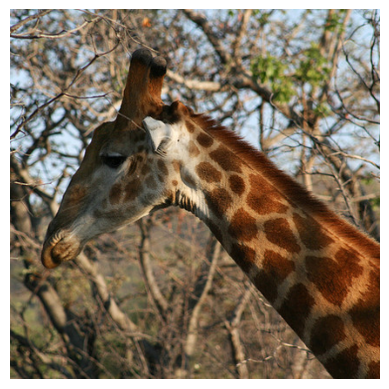

In [4]:
image_files = sorted(os.listdir(STIMULI_DIR))
first_image_path = os.path.join(STIMULI_DIR, image_files[0])
first_image = Image.open(first_image_path)


plt.imshow(first_image)
plt.axis('off')  # Hide axes
plt.show()

In [5]:
lh_fmri_path = os.path.join(FMRI_DIR, "lh_training_fmri.npy")
rh_fmri_path = os.path.join(FMRI_DIR, "rh_training_fmri.npy")

lh_fmri_data = np.load(lh_fmri_path)
rh_fmri_data = np.load(rh_fmri_path)

print("LH fMRI data shape:", lh_fmri_data.shape)
print("RH fMRI data shape:", rh_fmri_data.shape)

LH fMRI data shape: (9841, 19004)
RH fMRI data shape: (9841, 20544)


In [6]:
image_files = sorted(os.listdir(STIMULI_DIR))
images = []
for image_file in image_files:
    image_path = os.path.join(STIMULI_DIR, image_file)
    image = Image.open(image_path)
    images.append(image)

print(f"Loaded {len(images)} training images.")

Loaded 9841 training images.


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = torch.nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
model.eval()


batch_size = 8  # Adjust based on your GPU memory
all_features = []

# Process images in batches
for i in range(0, len(images), batch_size):
    batch_images = images[i:i+batch_size]
    
    # Preprocess batch
    preprocessed_batch = [preprocess(image) for image in batch_images]
    preprocessed_batch = torch.stack(preprocessed_batch).to(device)
    
    print(f"Processing batch {i//batch_size + 1}/{(len(images) + batch_size - 1)//batch_size}, shape: {preprocessed_batch.shape}")
    
    # Extract features
    with torch.no_grad():
        batch_features = model(preprocessed_batch)
        
        # Ensure consistent dimensions even for single images
        # ResNet features are [batch_size, 2048, 1, 1] before squeezing
        batch_features = batch_features.reshape(batch_features.size(0), -1)  # Flatten to [batch_size, 2048]
    
    # Move features to CPU to free GPU memory
    all_features.append(batch_features.cpu())
    
    # Clear GPU cache
    torch.cuda.empty_cache()

# Combine all features - now all have the same dimensions
features = torch.cat(all_features, dim=0)
print("Final extracted features shape:", features.shape)

Using device: cuda:0
Processing batch 1/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 2/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 3/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 4/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 5/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 6/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 7/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 8/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 9/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 10/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 11/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 12/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 13/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 14/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 15/1231, shape: torch.Size([8, 3, 224, 224])
Processing batch 16/1231, shape: torch.Size([8, 3, 224, 22

In [8]:
combined_fmri_data = np.concatenate([lh_fmri_data, rh_fmri_data], axis=1)
combined_fmri_data.shape

(9841, 39548)

In [55]:
roi_mask = np.load("/ssd_scratch/cvit/souvik/subj02/roi_masks/lh.floc-faces_fsaverage_space.npy")
roi_mask.shape[0], lh_fmri_data.shape

(163842, (9841, 19004))

In [86]:
import numpy as np

# Load fMRI data (time × vertices)
lh_fmri_data = np.load(lh_fmri_path)  # (9841, 19004)

# Load ROI mask (vertices,)
roi_mask_lh_faces = np.load("/ssd_scratch/cvit/souvik/subj02/roi_masks/lh.floc-faces_challenge_space.npy")
roi_mask_rh_faces = np.load("/ssd_scratch/cvit/souvik/subj02/roi_masks/rh.floc-faces_challenge_space.npy")
vertex_mapping = np.load("/ssd_scratch/cvit/souvik/subj02/roi_masks/mapping_floc-faces.npy", allow_pickle=True)




In [87]:
roi_mask_lh_faces.shape

(19004,)

In [88]:
# Define the categories
categories = ['faces','places', 'bodies', 'words']

# Initialize dictionaries to store the concatenated data
lh_data = {}
rh_data = {}
combined_data = {}

# Process each category
for category in categories:
    # Load the ROI masks for the left and right hemispheres
    lh_roi_mask = np.load(f"/ssd_scratch/cvit/souvik/subj02/roi_masks/lh.floc-{category}_challenge_space.npy")
    rh_roi_mask = np.load(f"/ssd_scratch/cvit/souvik/subj02/roi_masks/rh.floc-{category}_challenge_space.npy")
    
    # Extract fMRI data for the ROI vertices
    lh_data[category] = lh_fmri_data[:, lh_roi_mask > 0]
    rh_data[category] = rh_fmri_data[:, rh_roi_mask > 0]
    
    # Concatenate the left and right hemisphere data
    combined_data[category] = np.concatenate([lh_roi_mask, rh_roi_mask], axis=0)
    
    # Print the shapes to verify
    print(f"{category.capitalize()} - LH data shape: {lh_data[category].shape}")
    print(f"{category.capitalize()} - RH data shape: {rh_data[category].shape}")
    print(f"{category.capitalize()} - Combined data shape: {combined_data[category].shape}")

Faces - LH data shape: (9841, 1138)
Faces - RH data shape: (9841, 1916)
Faces - Combined data shape: (39548,)
Places - LH data shape: (9841, 3247)
Places - RH data shape: (9841, 4607)
Places - Combined data shape: (39548,)
Bodies - LH data shape: (9841, 4117)
Bodies - RH data shape: (9841, 4398)
Bodies - Combined data shape: (39548,)
Words - LH data shape: (9841, 1634)
Words - RH data shape: (9841, 1572)
Words - Combined data shape: (39548,)


In [67]:
roi_mask.shape, lh_fmri_data.shape

((19004,), (9841, 19004))

In [69]:
vertex_mapping

array({0: 'Unknown', 1: 'OFA', 2: 'FFA-1', 3: 'FFA-2', 4: 'mTL-faces', 5: 'aTL-faces'},
      dtype=object)

In [64]:
print(np.unique(roi_mask, return_counts=True))

(array([0, 1, 2, 3]), array([162704,    493,    244,    401]))


In [ ]:
# Ensure vertex mapping is within bounds
assert np.all((vertex_mapping >= 0) & (vertex_mapping < 163842)), "Invalid vertex mapping indices!"

# Map ROI mask to fMRI vertex indices
roi_vertices = roi_mask[vertex_mapping]  # Extract the ROI labels for the 19004 vertices

# Convert mask to boolean (in case it contains integers)
roi_mask_bool = roi_vertices > 0  # Convert to boolean mask

# Extract fMRI signals for ROI vertices
roi_fmri_data = lh_fmri_data[:, roi_mask_bool]  # Shape: (9841, N_roi_vertices)

print("Extracted fMRI data shape:", roi_fmri_data.shape)

In [9]:
X, y = combined_fmri_data, features
assert X.shape[0] == y.shape[0]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (7872, 39548) torch.Size([7872, 2048])
Testing data shape: (1969, 39548) torch.Size([1969, 2048])


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Function to load images from a directory
def load_images_from_folder(folder):
    image_list = []
    filenames = sorted(os.listdir(folder))  # Sorting ensures matching order
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format
        image_list.append(img)
    return image_list, filenames

# Load train and test images
train_images, train_filenames = load_images_from_folder(STIMULI_DIR)  # Assuming training and test images are in STIMULI_DIR
test_images, test_filenames = train_images[:len(y_test_scaled)], train_filenames[:len(y_test_scaled)]  # Adjust based on split

print(f"Loaded {len(train_images)} training images and {len(test_images)} test images.")



Loaded 9841 training images and 1969 test images.


### Doing with all features of FMRI that are in the challenge space

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Reshape y_train and y_test
y_train = y_train.squeeze()  # Remove singleton dimensions
y_test = y_test.squeeze()  # Remove singleton dimensions

# Verify the shapes
print("Reshaped y_train shape:", y_train.shape)
print("Reshaped y_test shape:", y_test.shape)

# Step 2: Scale the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Step 3: Reduce dimensionality with PCA
# pca = PCA(n_components=100)  # Adjust n_components as needed
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# Step 4: Train a Ridge Regression model
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0])  # Test different alpha values
ridge_model.fit(X_train_scaled, y_train_scaled)


Reshaped y_train shape: torch.Size([7872, 2048])
Reshaped y_test shape: torch.Size([1969, 2048])


ValueError: Found input variables with inconsistent numbers of samples: [1969, 7872]

In [78]:

# Evaluate the model
score = ridge_model.score(X_train_scaled, y_train_scaled)
print("Ridge Regression R^2 score after scaling:", score)

# Step 5: Predict embeddings for test data
predicted_embeddings = ridge_model.predict(X_test_scaled)

# Step 6: Compute similarity scores
similarity_scores = cosine_similarity(predicted_embeddings, y_test_scaled)

# Step 7: Find top 5 matches
top_5_indices = np.argsort(similarity_scores, axis=1)[:, -5:]
for i, indices in enumerate(top_5_indices):
    print(f"Top 5 matches for test sample {i}:")
    for idx in indices:
        print(f"Image: {image_files[idx]}, Similarity Score: {similarity_scores[i, idx]}")

Ridge Regression R^2 score after scaling: 0.9999602411992026
Top 5 matches for test sample 0:
Image: train-0482_nsd-03423.png, Similarity Score: 0.18845892776854908
Image: train-1745_nsd-12465.png, Similarity Score: 0.18897026473312292
Image: train-1419_nsd-10132.png, Similarity Score: 0.20670555583726388
Image: train-0940_nsd-06560.png, Similarity Score: 0.21200945934949378
Image: train-1626_nsd-11669.png, Similarity Score: 0.2146253373661317
Top 5 matches for test sample 1:
Image: train-1103_nsd-07738.png, Similarity Score: 0.13989644694442394
Image: train-1609_nsd-11555.png, Similarity Score: 0.14399998239052964
Image: train-0226_nsd-01802.png, Similarity Score: 0.1461944526818923
Image: train-0592_nsd-04155.png, Similarity Score: 0.15445184015733593
Image: train-0689_nsd-04783.png, Similarity Score: 0.1656297025650682
Top 5 matches for test sample 2:
Image: train-0003_nsd-00044.png, Similarity Score: 0.18874062216374024
Image: train-1569_nsd-11295.png, Similarity Score: 0.188802593

In [82]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_scaled, predicted_embeddings)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.233620580234162


In [89]:
y_test_scaled.shape

(1969, 2048)

In [80]:
most_similar_indices = np.argmax(similarity_scores, axis=1)  # Get the index of the highest similarity for each test sample
print("Most similar training sample indices:", most_similar_indices)

Most similar training sample indices: [1625  688  940 ...  707 1651  252]


In [83]:
most_similar_features = y_train_scaled[most_similar_indices]  # Get the feature vectors of the most similar images
print("Shape of most similar features:", most_similar_features.shape)

Shape of most similar features: (1969, 2048)


loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


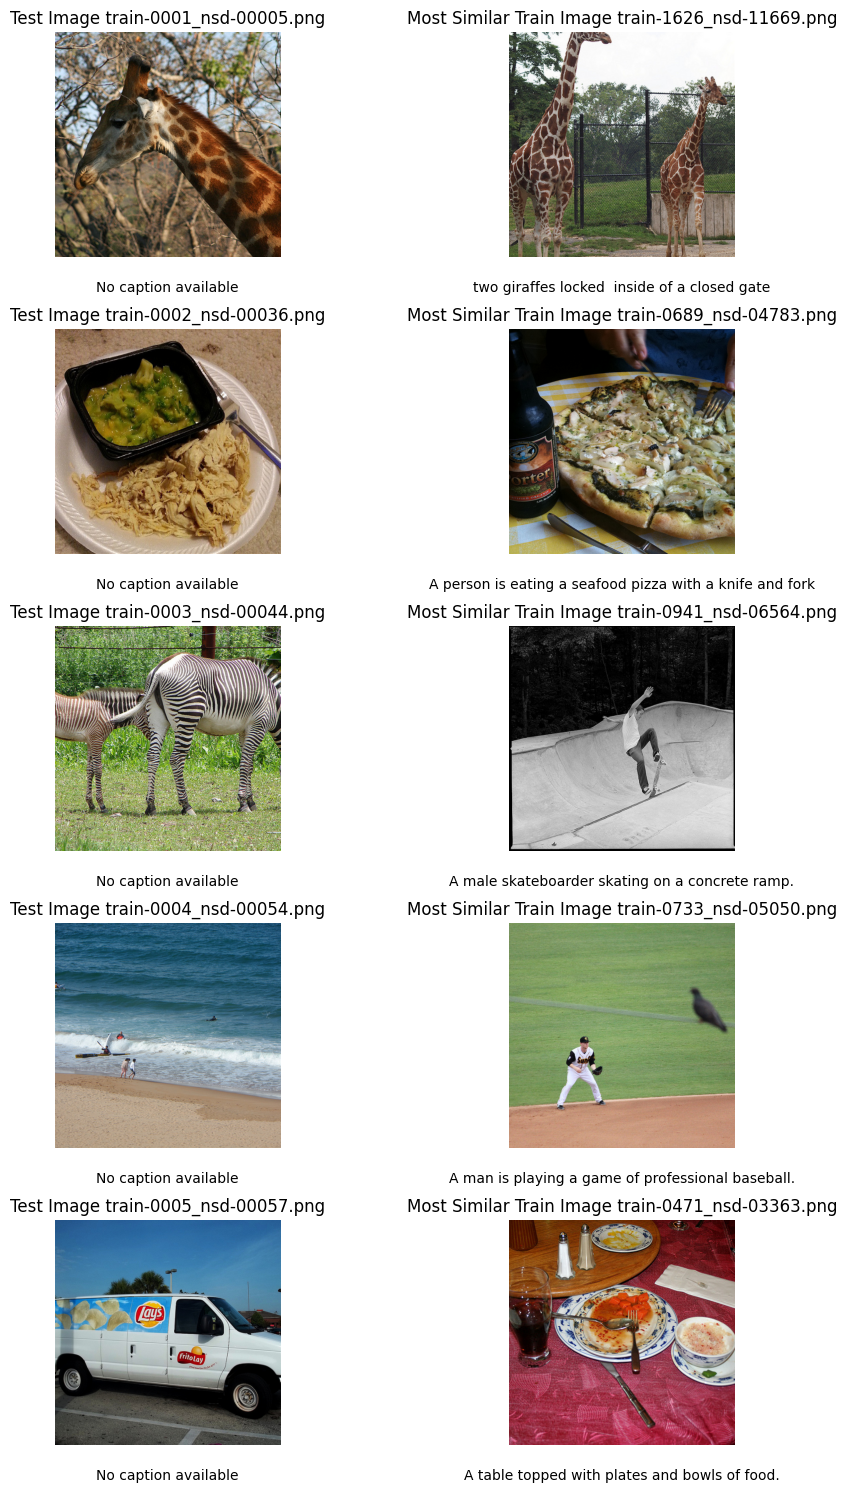

In [81]:
# Visualize some test images and their closest matches with captions
import pandas as pd

from pycocotools.coco import COCO

stim_descriptions = pd.read_csv('nsd_stim_info_merged.csv',
                                index_col=0)
num_samples = 5  # Number of pairs to visualize
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 15))

for i in range(num_samples):
    test_idx = i
    train_idx = most_similar_indices[i]
    match = re.search(r'nsd-(\d+)', train_filenames[train_idx])

    nsd_id = match.group(1)
    coco_id = stim_descriptions[stim_descriptions['nsdId'] == int(nsd_id)]['cocoId'].values[0]
    coco_split = stim_descriptions[stim_descriptions['nsdId'] == int(nsd_id)]['cocoSplit'].values[0]

    # Ensure the correct path to the COCO annotation file
    coco_annotation_file = f'/ssd_scratch/cvit/souvik/annotations/captions_{coco_split}.json'

    # Load COCO annotation data
    coco_data = COCO(coco_annotation_file)

    # Get captions for the image
    coco_ann_ids = coco_data.getAnnIds(imgIds=[coco_id])
    coco_annotations = coco_data.loadAnns(coco_ann_ids)

    # Get the first caption
    captions = [ann['caption'] for ann in coco_annotations]
    caption = captions[0] if captions else "No caption available"

    test_img = test_images[test_idx]  # Now properly loaded
    train_img = train_images[train_idx]  # Now properly loaded

    # Plot test image
    axes[i, 0].imshow(test_img)
    axes[i, 0].set_title(f"Test Image {test_filenames[test_idx]}")
    axes[i, 0].axis("off")
    axes[i, 0].text(0.5, -0.1, "No caption available", ha='center', va='top', transform=axes[i, 0].transAxes)

    # Plot train image with caption
    axes[i, 1].imshow(train_img)
    axes[i, 1].set_title(f"Most Similar Train Image {train_filenames[train_idx]}")
    axes[i, 1].axis("off")
    axes[i, 1].text(0.5, -0.1, caption, ha='center', va='top', transform=axes[i, 1].transAxes)

plt.tight_layout()
plt.show()

In [84]:
print("Alpha values tested:", ridge_model.alphas)
print("Best alpha selected:", ridge_model.alpha_)
print("Coefficients shape:", ridge_model.coef_.shape)
print("Intercept:", ridge_model.intercept_)

Alpha values tested: [0.1, 1.0, 10.0]
Best alpha selected: 10.0
Coefficients shape: (2048, 39548)
Intercept: [ 2.25660500e-08 -8.75724949e-10  7.73994783e-09 ...  7.74923107e-09
  3.87166690e-09  3.08024929e-09]


In [105]:
cf_avg = np.sum(ridge_model.coef_, axis=0)
print("Summed coefficients shape:", cf_avg.shape)


Summed coefficients shape: (39548,)


In [107]:
import numpy as np

# Assuming you have these variables:
# coefficients: numpy array of shape (39548,)
# roi_masks: dictionary with keys like 'face', 'places', etc.
#           Each value is a numpy array of shape (39548,)

# Create a dictionary to store the filtered results
filtered_results = {}

# Process each ROI mask
for category, mask in combined_data.items():
    # Find indices where mask > 0
    active_indices = np.where(mask > 0)[0]
    
    # Get the corresponding values from coefficients and mask
    filtered_coefficients = cf_avg[active_indices]
    filtered_mask = mask[active_indices]
    
    # Store the results
    filtered_results[category] = {
        'indices': active_indices,
        'coefficients': filtered_coefficients,
        'mask_values': filtered_mask
    }

# Example of accessing the results
# For example, to access the filtered coefficients for 'face' category:
# face_coefficients = filtered_results['face']['coefficients']

In [108]:
filtered_results.keys()

dict_keys(['faces', 'places', 'bodies', 'words'])

In [109]:
np.unique(filtered_results['faces']['mask_values'])

array([1, 2, 3])

In [110]:
import numpy as np

# Continuing from the previous code with filtered_results dictionary

# Dictionary to store mean coefficients for each unique mask value in each category
mean_coefficients_by_mask_value = {}

for category, data in filtered_results.items():
    filtered_coefficients = data['coefficients']
    filtered_mask_values = data['mask_values']
    
    # Find unique mask values
    unique_mask_values = np.unique(filtered_mask_values)
    
    # Dictionary to store mean coefficients for this category
    category_means = {}
    
    # Calculate mean coefficient for each unique mask value
    for mask_value in unique_mask_values:
        # Get indices where the mask has this specific value
        indices = np.where(filtered_mask_values == mask_value)[0]
        
        # Get coefficients corresponding to these indices
        coeffs_for_mask_value = filtered_coefficients[indices]
        
        # Calculate mean coefficient for this mask value
        mean_coeff = np.mean(coeffs_for_mask_value)
        
        # Store the result
        category_means[mask_value] = mean_coeff
    
    # Add to the main dictionary
    mean_coefficients_by_mask_value[category] = category_means

# Display the results
for category, mask_means in mean_coefficients_by_mask_value.items():
    print(f"\nCategory: {category}")
    print("Mask Value | Mean Coefficient")
    print("-------------------------")
    for mask_value, mean_coeff in sorted(mask_means.items()):
        print(f"{mask_value:.2f} | {mean_coeff:.6f}")


Category: faces
Mask Value | Mean Coefficient
-------------------------
1.00 | 0.077069
2.00 | -0.040121
3.00 | 0.213509

Category: places
Mask Value | Mean Coefficient
-------------------------
1.00 | -0.039039
2.00 | 0.003605
3.00 | 0.011756

Category: bodies
Mask Value | Mean Coefficient
-------------------------
1.00 | -0.009084
3.00 | -0.101082

Category: words
Mask Value | Mean Coefficient
-------------------------
1.00 | -0.019729
2.00 | 0.007882
3.00 | -0.184119
4.00 | -0.042282


In [111]:
vertex_mapping_face = np.load("/ssd_scratch/cvit/souvik/subj02/roi_masks/mapping_floc-faces.npy", allow_pickle=True)
vertex_mapping_places = np.load("/ssd_scratch/cvit/souvik/subj02/roi_masks/mapping_floc-places.npy", allow_pickle=True)
vertex_mapping_bodies = np.load("/ssd_scratch/cvit/souvik/subj02/roi_masks/mapping_floc-bodies.npy", allow_pickle=True)
vertex_mapping_words = np.load("/ssd_scratch/cvit/souvik/subj02/roi_masks/mapping_floc-words.npy", allow_pickle=True)
print("Face vertex mapping shape:", vertex_mapping_face)
print("Places vertex mapping shape:", vertex_mapping_places)
print("Bodies vertex mapping shape:", vertex_mapping_bodies)
print("Words vertex mapping shape:", vertex_mapping_words)  

Face vertex mapping shape: {0: 'Unknown', 1: 'OFA', 2: 'FFA-1', 3: 'FFA-2', 4: 'mTL-faces', 5: 'aTL-faces'}
Places vertex mapping shape: {0: 'Unknown', 1: 'OPA', 2: 'PPA', 3: 'RSC'}
Bodies vertex mapping shape: {0: 'Unknown', 1: 'EBA', 2: 'FBA-1', 3: 'FBA-2', 4: 'mTL-bodies'}
Words vertex mapping shape: {0: 'Unknown', 1: 'OWFA', 2: 'VWFA-1', 3: 'VWFA-2', 4: 'mfs-words', 5: 'mTL-words'}


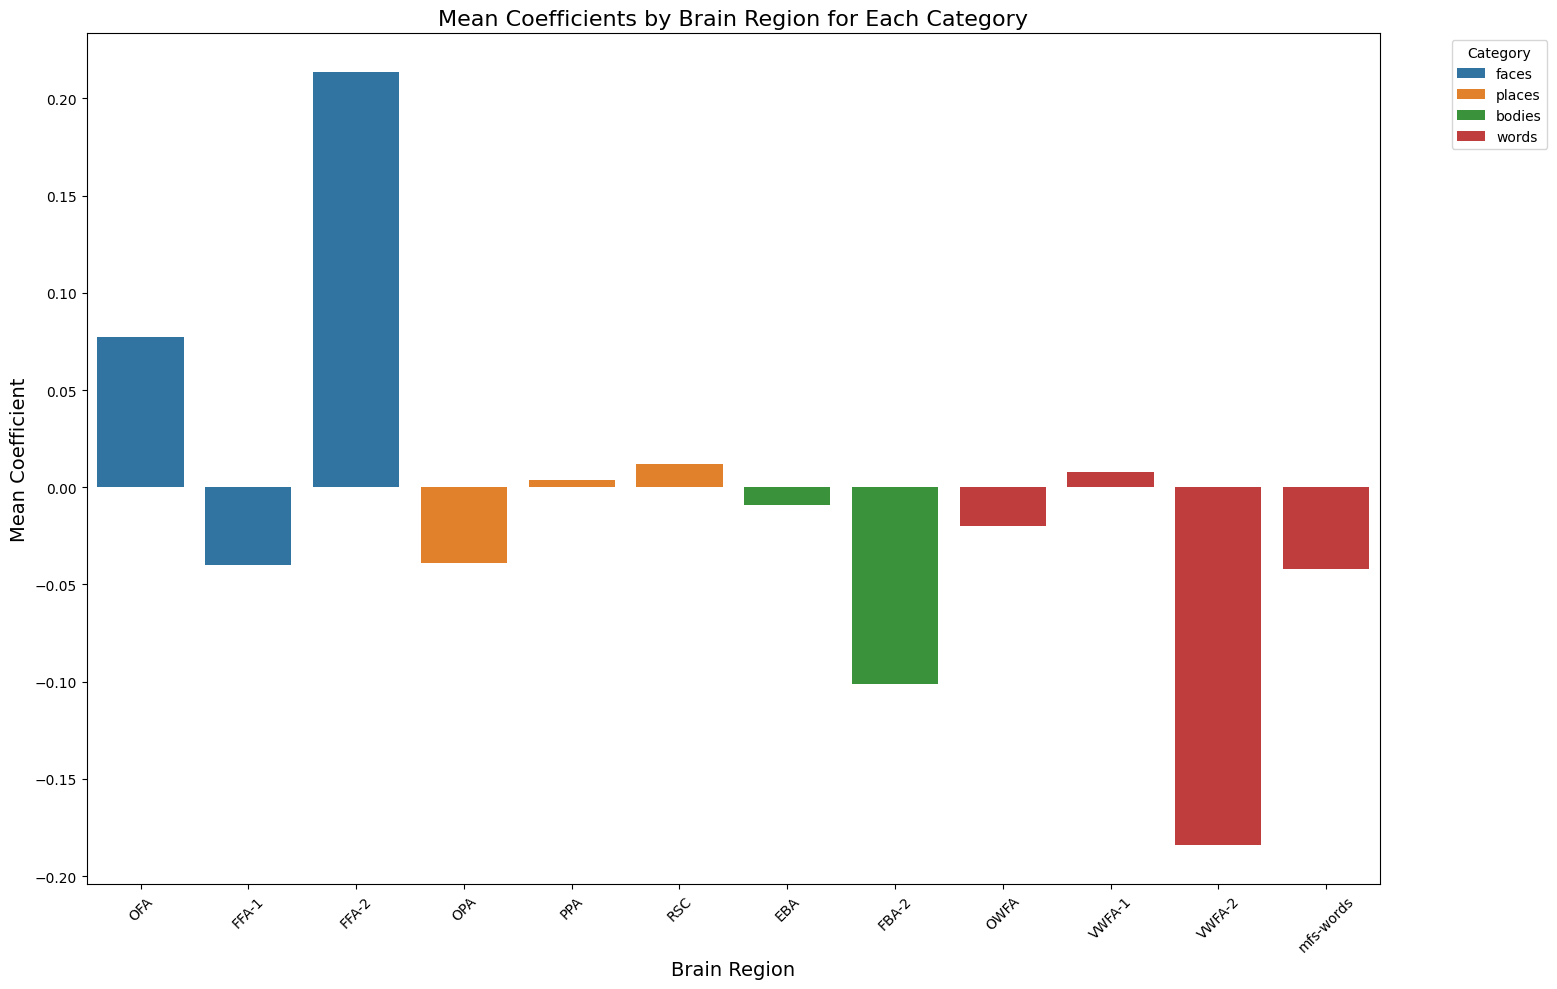

/tmp/ipykernel_40444/2216448221.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment='right')
/tmp/ipykernel_40444/2216448221.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment='right')
/tmp/ipykernel_40444/2216448221.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment='right')
/tmp/ipykernel_40444/2216448221.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabe

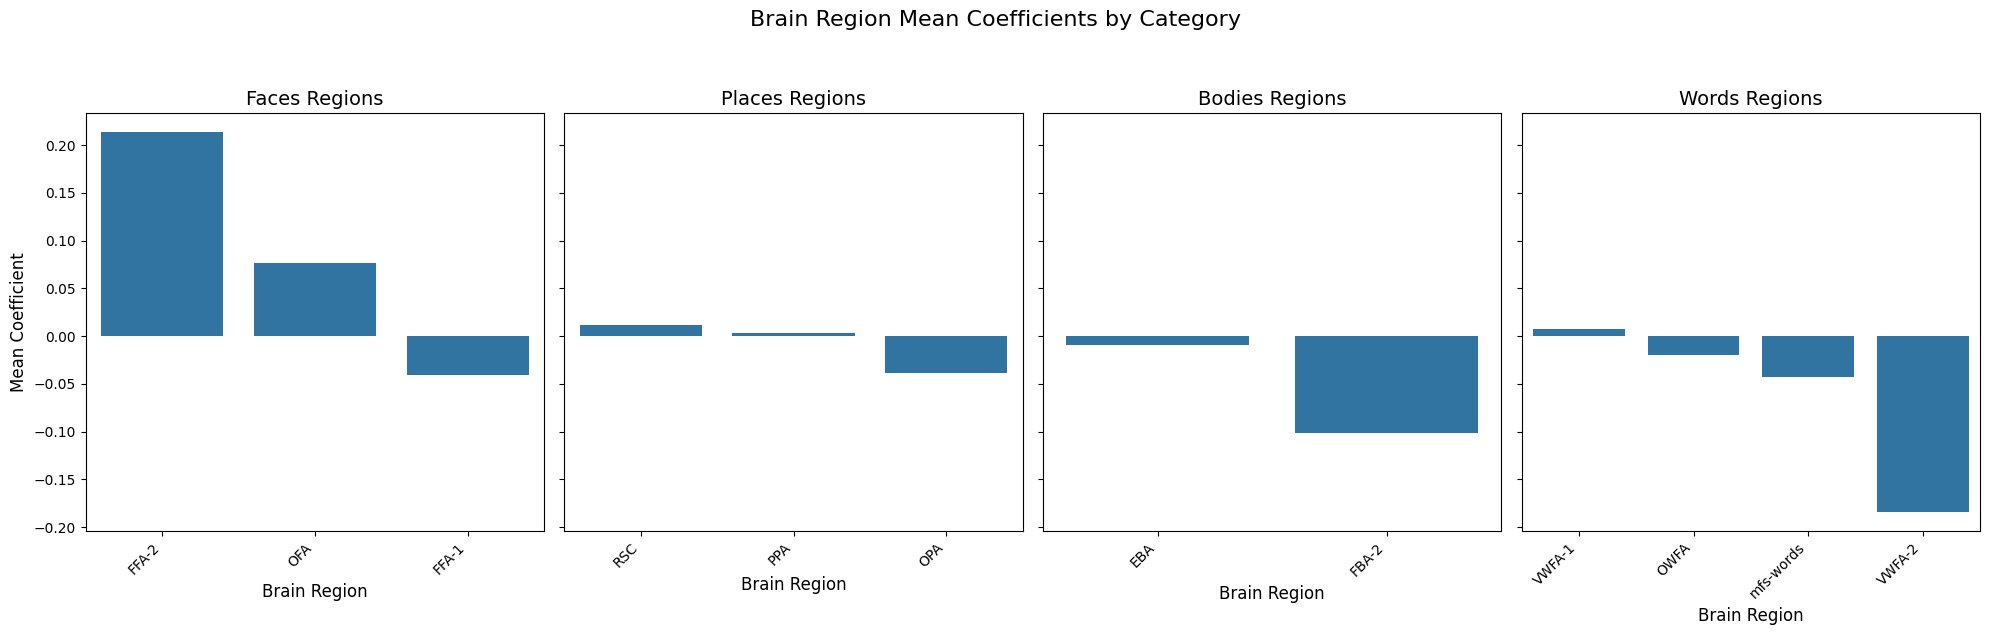

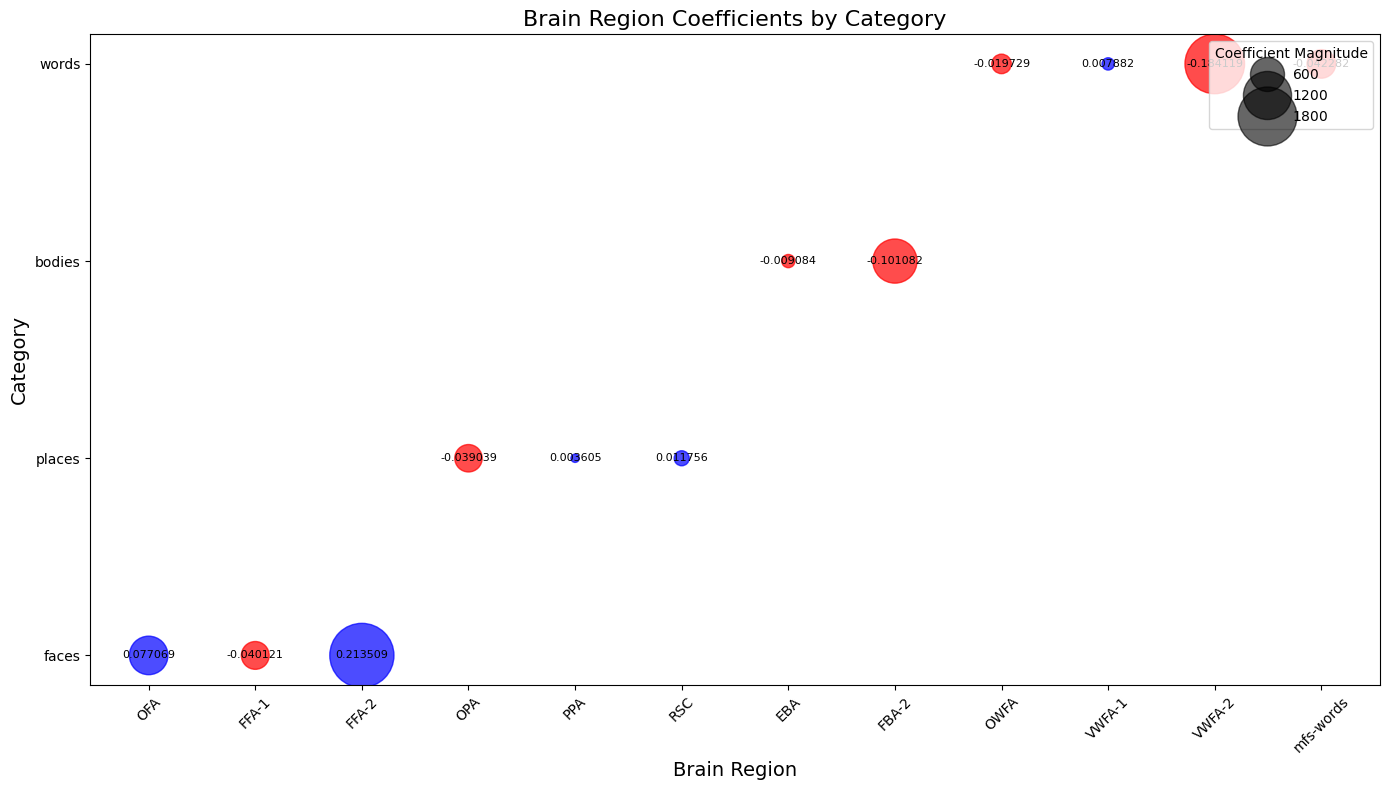

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the region mappings with the CORRECT category names to match your data
region_mappings = {
    'faces': {0: 'Unknown', 1: 'OFA', 2: 'FFA-1', 3: 'FFA-2', 4: 'mTL-faces', 5: 'aTL-faces'},
    'places': {0: 'Unknown', 1: 'OPA', 2: 'PPA', 3: 'RSC'},
    'bodies': {0: 'Unknown', 1: 'EBA', 2: 'FBA-1', 3: 'FBA-2', 4: 'mTL-bodies'},
    'words': {0: 'Unknown', 1: 'OWFA', 2: 'VWFA-1', 3: 'VWFA-2', 4: 'mfs-words', 5: 'mTL-words'}
}

# Continuing from previous code that created mean_coefficients_by_mask_value

# Convert the nested dictionary to a DataFrame with proper region names
data_for_plot = []

for category, mask_means in mean_coefficients_by_mask_value.items():
    if category in region_mappings:
        for mask_value, mean_coeff in mask_means.items():
            # Convert mask value to integer for lookup
            try:
                mask_value_int = int(float(mask_value))
                
                # Get the region name from the mapping
                region_name = region_mappings[category].get(mask_value_int, f"Value {mask_value_int}")
                
                data_for_plot.append({
                    'Category': category,
                    'Mask Value': mask_value_int,
                    'Region Name': region_name,
                    'Mean Coefficient': mean_coeff
                })
            except (ValueError, TypeError):
                # If conversion fails, use the original value
                data_for_plot.append({
                    'Category': category,
                    'Mask Value': mask_value,
                    'Region Name': f"Value {mask_value}",
                    'Mean Coefficient': mean_coeff
                })
    else:
        # For categories not in the mapping, use the original mask values
        for mask_value, mean_coeff in mask_means.items():
            data_for_plot.append({
                'Category': category,
                'Mask Value': mask_value,
                'Region Name': f"Value {mask_value}",
                'Mean Coefficient': mean_coeff
            })

df = pd.DataFrame(data_for_plot)

# Filter out "Unknown" regions if desired
df_filtered = df[df['Region Name'] != 'Unknown']

# Create a figure with sufficient size
plt.figure(figsize=(14, 10))

# Create a grouped bar chart using seaborn with region names
ax = sns.barplot(x='Region Name', y='Mean Coefficient', hue='Category', data=df_filtered)

# Enhance the plot
plt.title('Mean Coefficients by Brain Region for Each Category', fontsize=16)
plt.xlabel('Brain Region', fontsize=14)
plt.ylabel('Mean Coefficient', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

# Create a separate plot for each category
categories = df['Category'].unique()
n_categories = len(categories)
fig, axes = plt.subplots(1, n_categories, figsize=(5*n_categories, 6), sharey=True)

for i, category in enumerate(categories):
    category_data = df[df['Category'] == category]
    category_data = category_data[category_data['Region Name'] != 'Unknown']  # Remove Unknown
    
    # Sort by mean coefficient to highlight strongest regions
    category_data = category_data.sort_values('Mean Coefficient', ascending=False)
    
    # Create the bar plot for this category
    sns.barplot(x='Region Name', y='Mean Coefficient', data=category_data, ax=axes[i])
    
    # Customize this subplot
    axes[i].set_title(f'{category.capitalize()} Regions', fontsize=14)
    axes[i].set_xlabel('Brain Region', fontsize=12)
    if i == 0:
        axes[i].set_ylabel('Mean Coefficient', fontsize=12)
    else:
        axes[i].set_ylabel('')
    
    # Set rotation for x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment='right')

plt.suptitle('Brain Region Mean Coefficients by Category', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Create a more informative visualization: categorical scatter plot
plt.figure(figsize=(14, 8))

# Use a scatter plot with size representing the absolute value of the mean coefficient
sizes = np.abs(df_filtered['Mean Coefficient']) * 10000  # Scale factor for better visibility
colors = np.where(df_filtered['Mean Coefficient'] > 0, 'blue', 'red')  # Blue for positive, red for negative

scatter = plt.scatter(
    x=df_filtered['Region Name'], 
    y=df_filtered['Category'],
    s=sizes,
    c=colors,
    alpha=0.7
)

# Add text annotations with the actual values
for i, row in df_filtered.iterrows():
    plt.text(
        i % len(df_filtered['Region Name'].unique()),  # X position
        df_filtered['Category'].unique().tolist().index(row['Category']),  # Y position
        f"{row['Mean Coefficient']:.6f}",  # Text (formatted value)
        ha='center', va='center',
        fontsize=8, color='black'
    )

plt.title('Brain Region Coefficients by Category', fontsize=16)
plt.xlabel('Brain Region', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend for the size
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4)
legend = plt.legend(handles, labels, loc="upper right", title="Coefficient Magnitude")

plt.show()